# **TRAINING**

In [1]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm

E0000 00:00:1738342448.225255      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0131 16:54:08.233162714      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0131 16:54:08.233177411      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0131 16:54:08.233180775      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0131 16:54:08.233183231      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0131 16:54:08.233185663      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## **DISTRIBUTION DEFINITIONS**

In [3]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [4]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1738342485.515085      13 service.cc:145] XLA service 0x557a2abef9a0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738342485.515135      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1738342485.515139      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1738342485.515142      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1738342485.515145      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1738342485.515147      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1738342485.515150      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1738342485.515153      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1738342485.515156      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 256


In [6]:
tfk.mixed_precision.set_global_policy("mixed_bfloat16")

## **DATA PREPROCESSING**

In [7]:
data = np.load('/kaggle/input/lung-cancer/lung_dataset_interpolated.npz')
full_slices = data['full_slices']
nodules = data['nodules']
tumor_classes = data['tumor_classes']

print("full_slices shape: ", full_slices.shape)
print("nodules shape: ", nodules.shape)
print("tumor_classes shape: ", tumor_classes.shape)

full_slices shape:  (2363, 512, 512)
nodules shape:  (2363, 138, 138)
tumor_classes shape:  (2363,)


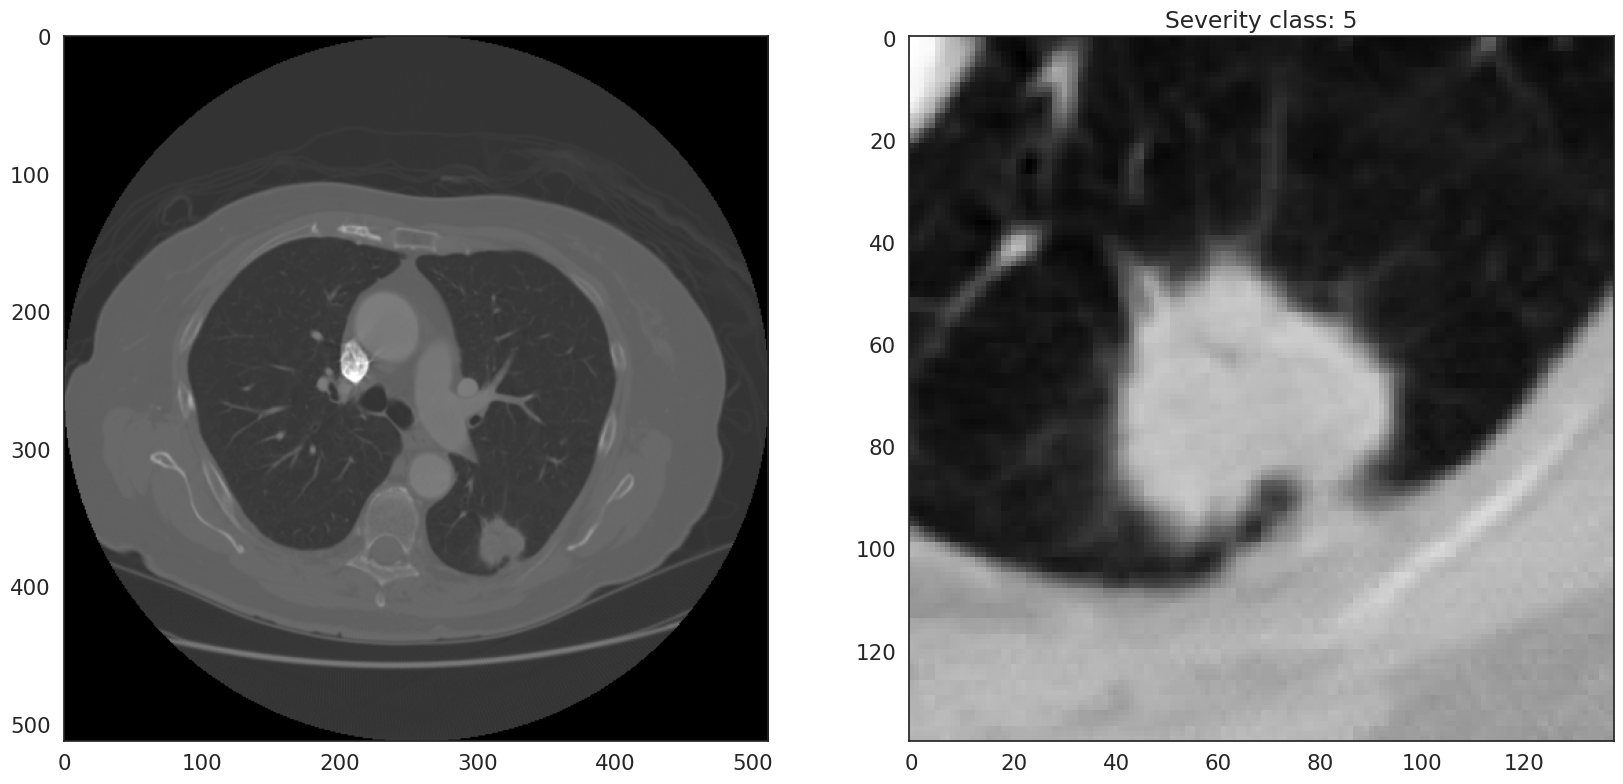

In [8]:
IMAGE_IDX = 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title(f"Severity class: {tumor_classes[IMAGE_IDX]}")

ax1.imshow(full_slices[IMAGE_IDX], cmap='gray')
ax2.imshow(nodules[IMAGE_IDX], cmap='gray')

plt.show()

In [9]:
# Normalize to values between 0 and 255
def normalize(x):
    return (x - np.min(x)) / (np.max(x) -  np.min(x))

In [10]:
# Normalize to values between 0 and 255
for i in range(full_slices.shape[0]):
    full_slices[i] = np.ceil(normalize(full_slices[i])*255)
full_slices = full_slices.astype("uint8")

/tmp/ipykernel_13/4014121241.py:3: RuntimeWarning: overflow encountered in scalar subtract
  return (x - np.min(x)) / (np.max(x) -  np.min(x))


In [11]:
import cv2 as cv

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
kernel = np.ones((3, 3), np.uint8)

def img_enhancer(img):
    img = cv.medianBlur(img, 3)
    img = cv.equalizeHist(img)
    img = clahe.apply(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    return img

def img_enhancer_logger(img):
    def plot_image(image, title='Image'):
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    plot_image(img)
    img = cv.medianBlur(img, 3)
    plot_image(img)
    img = cv.equalizeHist(img)
    plot_image(img)
    img = clahe.apply(img)
    plot_image(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    plot_image(img)
    return img

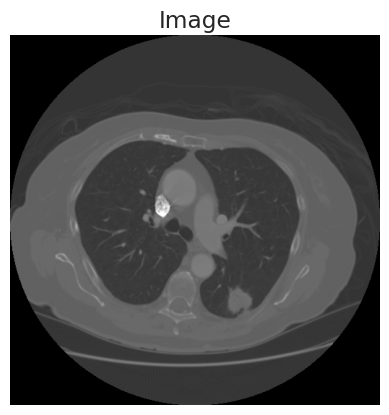

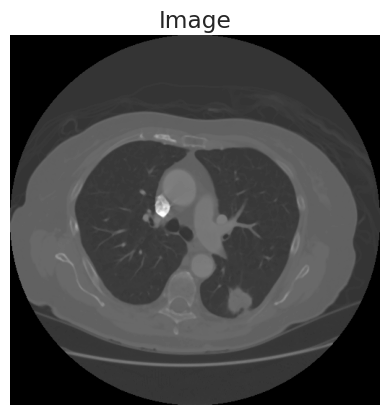

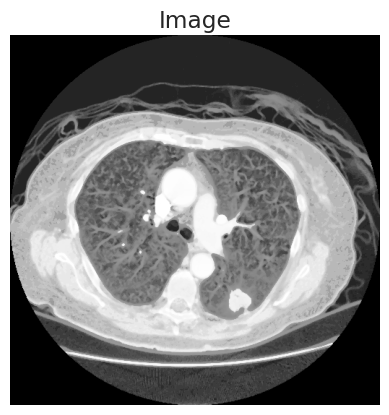

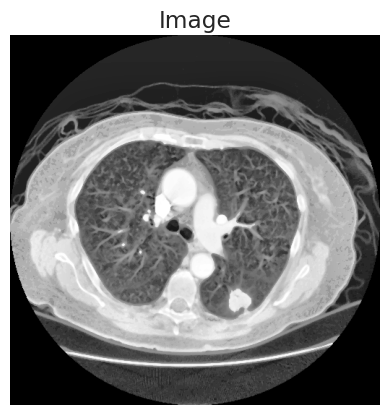

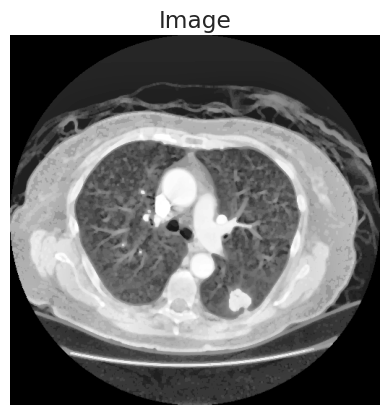

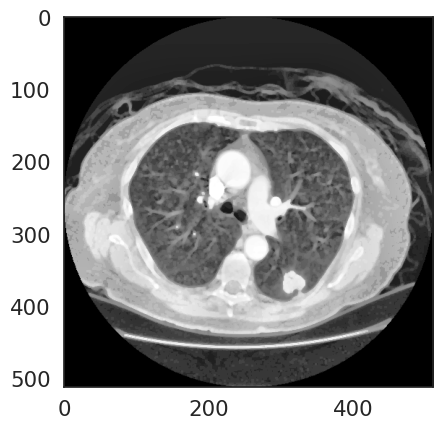

In [12]:
plt.title('After "enhancements"')
plt.imshow(img_enhancer_logger(full_slices[IMAGE_IDX]), cmap='gray')
plt.show()

In [13]:
# Enhance the images

processed_images = []
for img in full_slices:
    img = img_enhancer(img)
    processed_images.append(img)

full_slices = np.array(processed_images)

In [14]:
# subtract 1 from the class encoding because to_categorical expects starting index = 0
label_set = tfk.utils.to_categorical(tumor_classes - 1, num_classes=5)
label_set

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [15]:
def calculate_class_weight(Y):
    from sklearn.utils.class_weight import compute_class_weight

    y_integers = np.argmax(Y, axis=1)
    return compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)    

[1.93688525 1.03413567 0.43278388 1.13062201 3.10921053]


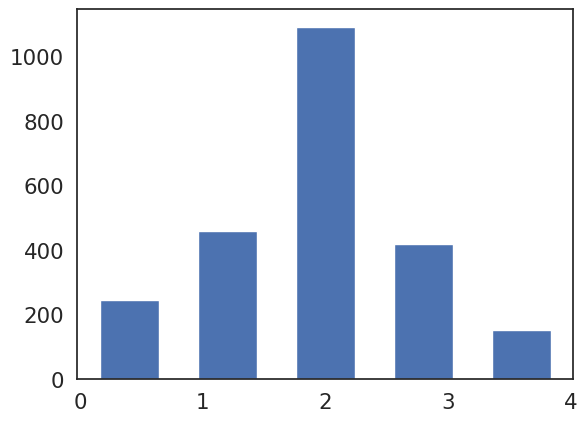

In [16]:
# Starting class weights (inverse frequencies)
class_weights = calculate_class_weight(label_set)

plt.hist(np.argmax(label_set, -1), bins=5,rwidth=0.6)
print(class_weights)

# d_class_weights = dict(enumerate(class_weights))

# import json # Just to prettify the debug
# print(json.dumps(d_class_weights, sort_keys=True, indent=1))

[1.00119798 0.99274773 0.96941392 0.94970096 1.09965374]
{
 "0": 1.0011979823455233,
 "1": 0.9927477336667708,
 "2": 0.9694139194139194,
 "3": 0.949700956937799,
 "4": 1.0996537396121884
}


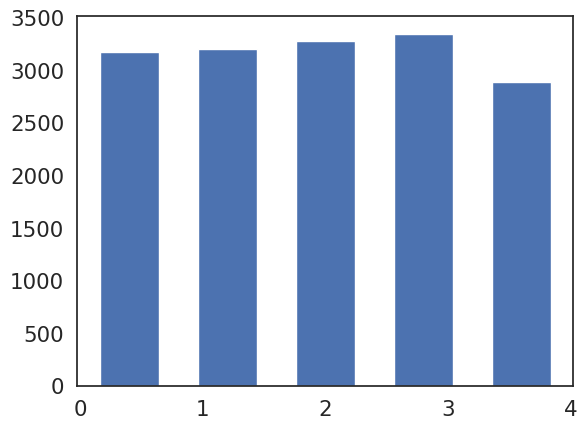

In [17]:
# Balance the dataset by applying random rotations
full_slices = np.expand_dims(full_slices, -1)

X_bal, y_bal = [], []
X_bal.extend(full_slices)
y_bal.extend(label_set)

while class_weights[4] > 1 + 0.1:
    # Repeat this while last class (the minority one) is "infrequent"
    for x, y in zip(full_slices, label_set):
        
        # Apply augmentation if class is infrequent
        if class_weights[np.argmax(y)] > 1:
            # Just rotation to not mess up too much the image distribution (thankfully they're only slices of the CT) 
            x = tfkl.RandomRotation(0.9)(x)
            X_bal.append(x)
            y_bal.append(y)
    
    # Recalculate weights
    class_weights = calculate_class_weight(y_bal)

X_balanced, y_balanced = np.asarray(X_bal), np.asarray(y_bal)

plt.hist(np.argmax(y_balanced, -1), bins=5,rwidth=0.6)
print(class_weights)


# These lines are now useless but ok
d_class_weights = dict(enumerate(class_weights))

import json # Just to prettify the debug
print(json.dumps(d_class_weights, sort_keys=True, indent=1))

In [18]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, shuffle=True)

X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

print("Train/Test mins ", np.min(X_train), np.min(X_test))
print("Train/Test maxs ", np.max(X_train), np.max(X_test))

Training set shape:  (11115, 512, 512, 1) (11115, 5)
Test set shape:  (4764, 512, 512, 1) (4764, 5)
Train/Test mins  0 0
Train/Test maxs  1 1


In [19]:
def perform_augmentation(X, Y, p):
    X_aug, y_aug = [], []
    for x, y in tqdm(zip(X, Y), total=len(X), desc="Augmenting data"):
        X_aug.append(x)
        y_aug.append(y)

        if np.random.random() < p: # random rotate the image and add it
            # It would be better to apply these independently
            x = tfkl.RandomRotation(0.9)(x)
            x = tfkl.RandomFlip()(x)
            x = tfkl.RandomTranslation(0.3, 0.3)(x)
            X_aug.append(x)
            y_aug.append(y)

    return np.asarray(X_aug), np.asarray(y_aug)

In [20]:
# Repeated training set augmentation for laughs
X_aug, y_aug = perform_augmentation(X_train, y_train, 0.75)
X_aug, y_aug = perform_augmentation(X_aug, y_aug, 0.2)

print("Augmented training set shape: ", X_aug.shape, y_aug.shape)

Augmenting data: 100%|██████████| 19457/19457 [02:38<00:00, 123.12it/s]


Augmented training set shape:  (23289, 512, 512, 1) (23289, 5)


## MODEL DEFINITION

In [21]:
def inception_block(inputs, filters, name):
    f1, f3, f5, fpool = filters

    # 1x1 convolution
    conv_1x1 = tfkl.Conv2D(f1, kernel_size=1, activation='relu', name=f"{name}_1x1_conv")(inputs)

    # 3x3 convolution
    conv_3x3 = tfkl.Conv2D(f3, kernel_size=3, padding='same', activation='relu', name=f"{name}_3x3_conv")(inputs)
    
    # 5x5 convolution
    conv_5x5 = tfkl.Conv2D(f5, kernel_size=5, padding='same', activation='relu', name=f"{name}_5x5_conv")(inputs)

    # Max pooling followed by 1x1 convolution
    max_pool = tfkl.MaxPooling2D(pool_size=3, strides=1, padding='same', name=f"{name}_max_pool")(inputs)
    max_pool = tfkl.Conv2D(fpool, kernel_size=1, activation='relu', name=f"{name}_pool_1x1_conv")(max_pool)

    # Concatenate all outputs
    output = tfkl.Concatenate(name=f"{name}_concat")([conv_1x1, conv_3x3, conv_5x5, max_pool])
    return output

def build_model(filters):
    f1, f2, f3, f4 = filters

    inputs = tfkl.Input(shape=(512, 512, 1), name='input')

    # Initial convolution
    x = tfkl.Conv2D(f1, kernel_size=3, activation='relu', name="conv_initial")(inputs)
    x = tfkl.MaxPooling2D(name="max_pool_initial")(x)

    # Inception block 1
    x = tfkl.Conv2D(f1, kernel_size=1, activation='relu', name="reduce_channels_2")(x)
    x = tfkl.Dropout(0.3, name="dropout_2")(x)
    x = inception_block(x, [f1, f2, f3, f4], name="inception_1")
    x = tfkl.SpatialDropout2D(0.2, name="spatial_dropout_1")(x)

    # Inception block 2
    x = tfkl.Conv2D(f3, kernel_size=1, activation='relu', name="reduce_channels_3")(x)
    x = tfkl.Dropout(0.4, name="dropout_3")(x)
    x = inception_block(x, [f2, f3, f4, f1], name="inception_2")
    x = tfkl.SpatialDropout2D(0.3, name="spatial_dropout_2")(x)

    # Global pooling and final classification
    x = tfkl.GlobalAveragePooling2D(name="global_avg_pooling")(x)
    x = tfkl.Dense(256, activation="silu")(x)
    x = tfkl.Dropout(0.4)(x)
    x = tfkl.Dense(5, activation="softmax", name="output")(x)

    model = tfk.Model(inputs=inputs, outputs=x, name="inception_model")
    model.compile(
        loss=tfk.losses.CategoricalFocalCrossentropy(alpha=list(d_class_weights.values())),
        optimizer=tfk.optimizers.AdamW(),
        metrics=['accuracy']
    )
    
    model.summary(expand_nested=True, show_trainable=True)
    return model

In [22]:
# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [23]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max', 
    patience=50,
    restore_best_weights=True
)

In [24]:
with strategy.scope():
    model = build_model(filters=(64, 64, 128, 256))

I0000 00:00:1738343364.871556      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "inception_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input             │ (None, 512,     │         0 │ -              │   -   │
│ (InputLayer)      │ 512, 1)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast (Cast)       │ (None, 512,     │         0 │ input[0][0]    │   -   │
│                   │ 512, 1)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv_initial      │ (None, 510,     │       640 │ cast[0][0]     │   Y   │
│ (Conv2D)          │ 510, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pool_initial  │ (None, 255,     │         0 │ conv_initial[… │   -   │
│ (MaxPooling2D)    │ 255, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_1_max_… │ (None, 255,     │         0 │ max_pool_init… │   -   │
│ (MaxPooling2D)    │ 255, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_1_1x1_… │ (None, 255,     │     4,160 │ max_pool_init… │   Y   │
│ (Conv2D)          │ 255, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_1_3x3_… │ (None, 255,     │    36,928 │ max_pool_init… │   Y   │
│ (Conv2D)          │ 255, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_1_5x5_… │ (None, 255,     │   204,928 │ max_pool_init… │   Y   │
│ (Conv2D)          │ 255, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_1_pool… │ (None, 255,     │    16,640 │ inception_1_m… │   Y   │
│ (Conv2D)          │ 255, 256)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_1_conc… │ (None, 255,     │         0 │ inception_1_1… │   -   │
│ (Concatenate)     │ 255, 512)       │           │ inception_1_3… │       │
│                   │                 │           │ inception_1_5… │       │
│                   │                 │           │ inception_1_p… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ spatial_dropout_1 │ (None, 255,     │         0 │ inception_1_c… │   -   │
│ (SpatialDropout2… │ 255, 512)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_2_max_… │ (None, 255,     │         0 │ spatial_dropo… │   -   │
│ (MaxPooling2D)    │ 255, 512)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_2_1x1_… │ (None, 255,     │    32,832 │ spatial_dropo… │   Y   │
│ (Conv2D)          │ 255, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_2_3x3_… │ (None, 255,     │   589,952 │ spatial_dropo… │   Y   │
│ (Conv2D)          │ 255, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_2_5x5_… │ (None, 255,     │ 3,277,056 │ spatial_dropo… │   Y   │
│ (Conv2D)          │ 255, 256)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ inception_2_pool… │ (None, 255,     │    32,832 │ inception_2_m… │   Y   │
│ (Conv2D)          │ 255, 64)        │           │                │     

 Total params: 4,328,581 (16.51 MB)

 Trainable params: 4,328,581 (16.51 MB)

 Non-trainable params: 0 (0.00 B)

## MODEL TRAINING

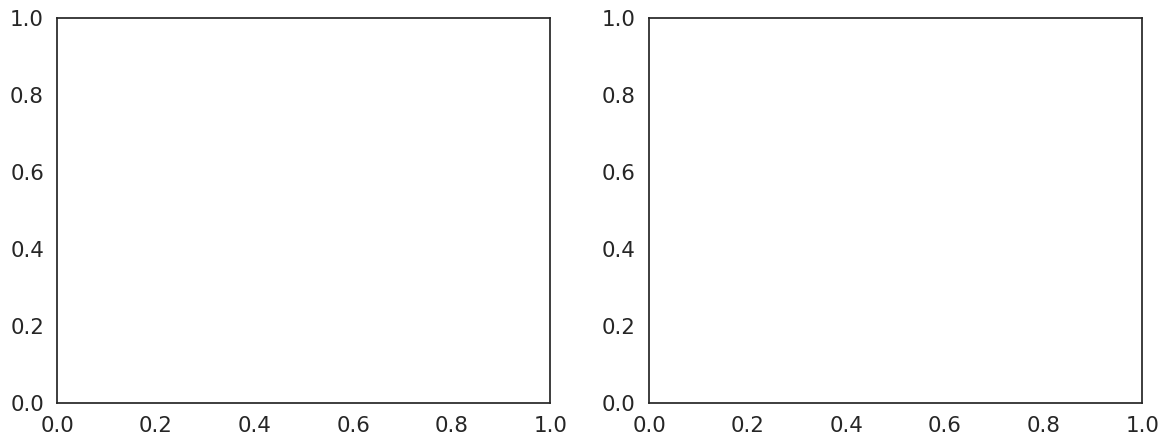

Epoch 1/1000


2025-01-31 17:10:22.319046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1738343423.227915     834 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b6dacbbcb9b9a885:0:0), session_name()


In [ ]:
history = model.fit(
    X_aug, 
    y_aug,
    epochs=1000,
    validation_split = 0.25, 
    batch_size=batch_size,
    callbacks=[early_stopping, RealTimePlot()],
    verbose=1
).history

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
print(X_test.shape)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
accuracy = round(test_accuracy, 4)
print(f'Test Accuracy: {accuracy}')

with strategy.scope():
    model.save(f"/kaggle/working/CustomCNN_{accuracy}.keras")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

classes = [1, 2, 3, 4, 5]

predictions = model.predict(X_test)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt=".4", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()